# XGBoost — Gradient Boosted Trees

This notebook covers XGBoost for bond excess return forecasting:
1. **Data loading** — shared data pipeline
2. **Feature engineering comparison** — PCA / group selection (no leakage)
3. **Hyperparameter sensitivity** — grid over key parameters
4. **Interpretation** — feature importance, partial dependence
5. **Robustness** — maturities, OOS start dates, subperiods

In [8]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils.base_utils as bu
import utils.window_utils as wu
from models.gbt import XGBoostModel

# ── Load data ──
start_date = '1971-09-30'
end_date = '2025-06-30'
maturities = ['1'] + [str(i) for i in range(1, 121) if i % 12 == 0]

kr_yields = bu.get_yields(type='kr', start=start_date, end=end_date, maturities=maturities)
kr_forward = bu.get_forward_rates(kr_yields)
kr_xr = bu.get_excess_returns(kr_yields).dropna()
fred_md_raw = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date)

# At time t (end of month), we only know data for month t-1
fred_md = fred_md_raw.shift(1)

# Drop dates after kr_xr becomes nan
kr_yields = kr_yields.loc[kr_yields.index <= kr_xr.index[-1]]
kr_forward = kr_forward.loc[kr_forward.index <= kr_xr.index[-1]]
kr_xr = kr_xr.loc[kr_xr.index <= kr_xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= kr_xr.index[-1]]
fred_md = fred_md.bfill()

# ── Feature matrix & target ──
OOS_start = pd.Timestamp('1989-01-31')

X = pd.concat([fred_md, kr_forward, kr_yields],
               axis=1, keys=['fred', 'forward', 'yields'])

y = kr_xr['24'].values  # 2-year excess returns
dates = kr_xr.index

# ── Shared defaults (used across all sections) ──
DEFAULT_FEATURES = {
    'fred':    {'method': 'pca', 'n_components': 8},
    'yields':  {'method': 'pca', 'n_components': 3},
    'forward': {'method': 'raw'},
}
XGB_DEFAULTS = dict(n_estimators=100, max_depth=3, learning_rate=0.1)

print(f"Features: {X.shape[1]},  Obs: {X.shape[0]},  OOS from: {OOS_start.date()}")

Features: 147,  Obs: 634,  OOS from: 1989-01-31


## 2. Feature engineering comparison

Compare different input representations — same XGBoost, different feature pipelines.
PCA and scaling are fit inside `model.fit()` on training data only (no leakage).

In [9]:
feature_configs = {
    'PCA macro(8) + PCA yields(3) + raw forwards': {
        'fred':    {'method': 'pca', 'n_components': 8},
        'yields':  {'method': 'pca', 'n_components': 3},
        'forward': {'method': 'raw'},
    },

    'PCA macro(8) + PCA yields(3)': {
        'fred':   {'method': 'pca', 'n_components': 8},
        'yields': {'method': 'pca', 'n_components': 3},
    },

    'PCA macro(5) + raw forwards': {
        'fred':    {'method': 'pca', 'n_components': 5},
        'forward': {'method': 'raw'},
    },

    'Forwards only': {
        'forward': {'method': 'raw'},
    },
}

feat_results = {}
for label, cfg in feature_configs.items():
    m = XGBoostModel(features=cfg, **XGB_DEFAULTS)
    yf = wu.expanding_window(m, X, y, dates, OOS_start)
    r2 = wu.oos_r2(y, yf)
    feat_results[label] = {'forecast': yf, 'R2_OOS': r2}
    print(f"{label:50s}  OOS R² = {r2:.4f}")

print("\n--- Feature engineering summary ---")
for label, res in feat_results.items():
    print(f"  {label:50s}  {res['R2_OOS']:.4f}")

Expanding window OOS: 100%|██████████| 426/426 [00:45<00:00,  9.30it/s]


PCA macro(8) + PCA yields(3) + raw forwards         OOS R² = 0.4144


Expanding window OOS: 100%|██████████| 426/426 [00:42<00:00, 10.05it/s]


PCA macro(8) + PCA yields(3)                        OOS R² = 0.3386


Expanding window OOS: 100%|██████████| 426/426 [00:45<00:00,  9.32it/s]


PCA macro(5) + raw forwards                         OOS R² = 0.3800


Expanding window OOS: 100%|██████████| 426/426 [00:40<00:00, 10.54it/s]

Forwards only                                       OOS R² = 0.2352

--- Feature engineering summary ---
  PCA macro(8) + PCA yields(3) + raw forwards         0.4144
  PCA macro(8) + PCA yields(3)                        0.3386
  PCA macro(5) + raw forwards                         0.3800
  Forwards only                                       0.2352


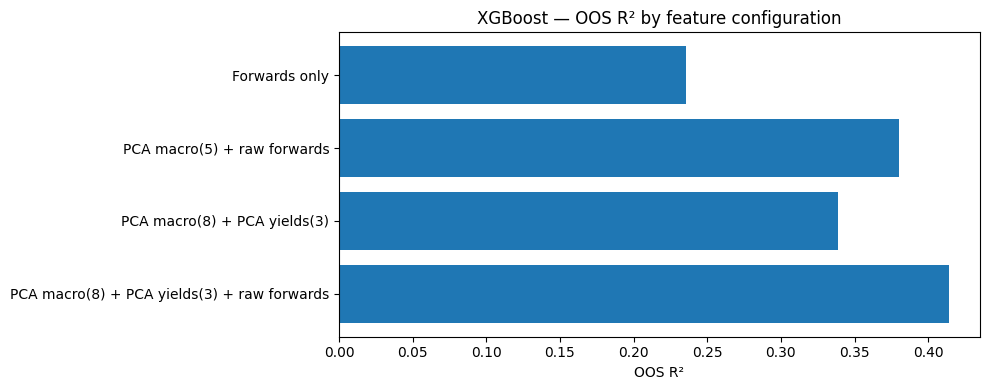

In [10]:
# Bar chart comparing feature configs
labels = list(feat_results.keys())
r2_vals = [feat_results[l]['R2_OOS'] for l in labels]

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.barh(labels, r2_vals)
ax.axvline(0, color='grey', lw=0.5)
ax.set_xlabel('OOS R²')
ax.set_title('XGBoost — OOS R² by feature configuration')
plt.tight_layout()
plt.show()

## 3. Hyperparameter sensitivity

Vary one parameter at a time to see how OOS R² responds.

In [11]:
param_grids = {
    'max_depth':        [3],
    'n_estimators':     [200],
    'learning_rate':    [0.1],
}

sensitivity_results = {}

for param_name, values in param_grids.items():
    print(f"\n=== {param_name} ===")
    scores = []
    for val in values:
        kwargs = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
        kwargs[param_name] = val
        m = XGBoostModel(features=DEFAULT_FEATURES, **kwargs)
        yf = wu.expanding_window(m, X, y, dates, OOS_start)
        r2 = wu.oos_r2(y, yf)
        scores.append(r2)
        print(f"  {param_name}={val:>6}  →  OOS R² = {r2:.4f}")
    sensitivity_results[param_name] = (values, scores)
    
    


=== max_depth ===


Expanding window OOS: 100%|██████████| 426/426 [00:47<00:00,  9.00it/s]


  max_depth=     3  →  OOS R² = 0.4239

=== n_estimators ===


Expanding window OOS: 100%|██████████| 426/426 [01:27<00:00,  4.89it/s]


  n_estimators=   200  →  OOS R² = 0.4589

=== learning_rate ===


Expanding window OOS: 100%|██████████| 426/426 [00:44<00:00,  9.51it/s]

  learning_rate=   0.1  →  OOS R² = 0.4222


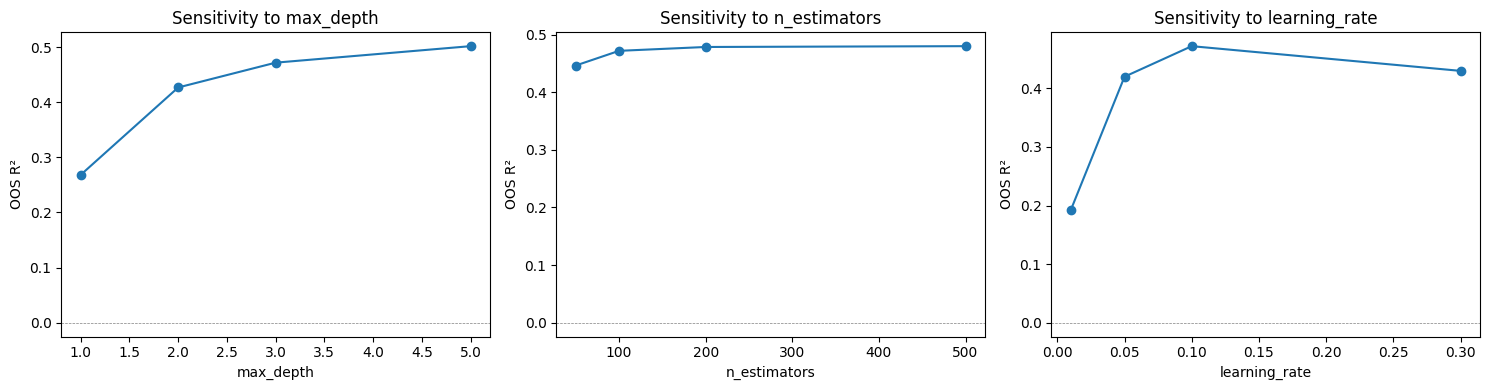

In [5]:
# Plot sensitivity
fig, axes = plt.subplots(1, len(sensitivity_results), figsize=(5 * len(sensitivity_results), 4))
for ax, (param_name, (values, scores)) in zip(axes, sensitivity_results.items()):
    ax.plot(values, scores, 'o-')
    ax.set_xlabel(param_name)
    ax.set_ylabel('OOS R²')
    ax.set_title(f'Sensitivity to {param_name}')
    ax.axhline(0, color='grey', lw=0.5, ls='--')
plt.tight_layout()
plt.show()

## 4. Interpretation

### 4a. Feature importance (full-sample fit)

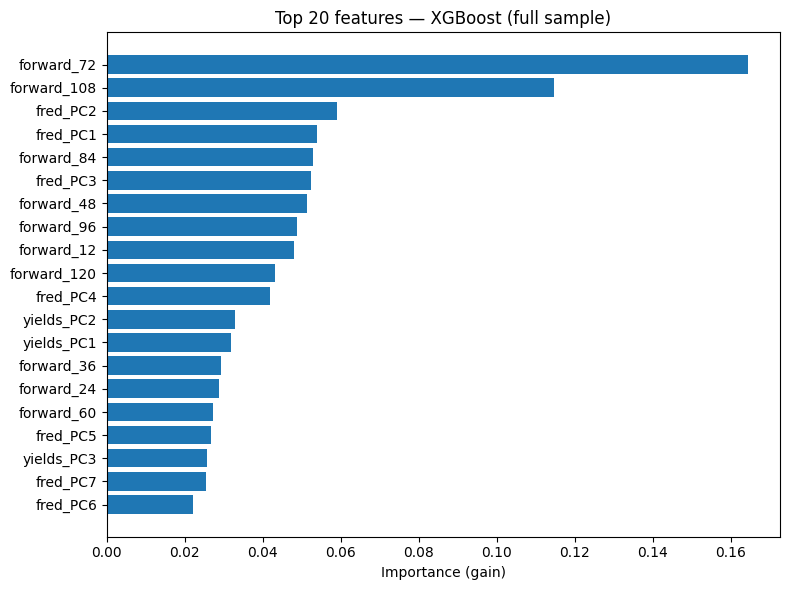

In [12]:
# Full-sample fit for interpretability (using default PCA features)
model_full = XGBoostModel(features=DEFAULT_FEATURES, **XGB_DEFAULTS)
model_full.fit(X, y)

# Build feature names matching the PCA-transformed features
feature_names = []
for group, cfg in DEFAULT_FEATURES.items():
    if cfg.get('method') == 'pca':
        for i in range(1, cfg['n_components'] + 1):
            feature_names.append(f'{group}_PC{i}')
    else:
        for col in X[group].columns:
            feature_names.append(f'{group}_{col}')

# XGBoost built-in importance (gain)
importances = model_full.model.feature_importances_
top_k = min(20, len(feature_names))
idx_sorted = np.argsort(importances)[-top_k:]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(range(top_k), importances[idx_sorted])
ax.set_yticks(range(top_k))
ax.set_yticklabels([feature_names[i] for i in idx_sorted])
ax.set_xlabel('Importance (gain)')
ax.set_title(f'Top {top_k} features — XGBoost (full sample)')
plt.tight_layout()
plt.show()

### 4b. Partial dependence — top features

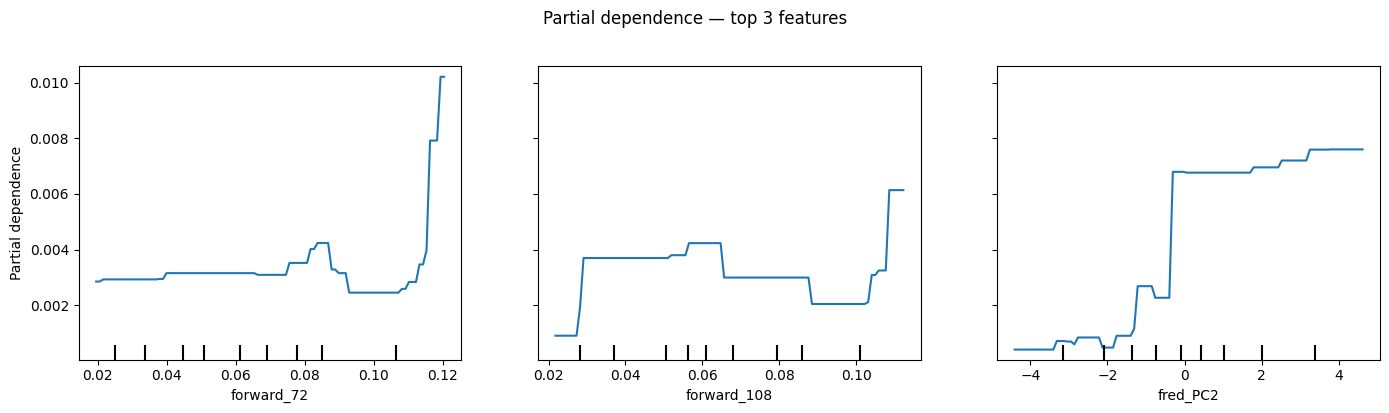

In [13]:
from sklearn.inspection import PartialDependenceDisplay

# Build the same transformed feature matrix used by the model
X_transformed = model_full._build_features(X, fit=False)

top_3_idx = np.argsort(importances)[-3:][::-1].tolist()

fig, ax = plt.subplots(figsize=(14, 4))
PartialDependenceDisplay.from_estimator(
    model_full.model, X_transformed, features=top_3_idx,
    feature_names=feature_names, ax=ax
)
fig.suptitle('Partial dependence — top 3 features', y=1.02)
plt.tight_layout()
plt.show()

## 5. Robustness

### 5a. Across maturities

In [14]:
target_maturities = ['24', '60', '120']  # 2y, 5y, 10y

maturity_results = {}
for mat in target_maturities:
    print(f"\nMaturity {int(mat)//12}y ({mat}m)...")
    y_mat = kr_xr[mat].values
    m = XGBoostModel(features=DEFAULT_FEATURES, **XGB_DEFAULTS)
    yf = wu.expanding_window(m, X, y_mat, dates, OOS_start)
    r2 = wu.oos_r2(y_mat, yf)
    maturity_results[mat] = r2
    print(f"  OOS R² = {r2:.4f}")

print("\n--- OOS R² by maturity ---")
for mat, r2 in maturity_results.items():
    print(f"  {int(mat)//12}y: {r2:.4f}")


Maturity 2y (24m)...


Expanding window OOS: 100%|██████████| 426/426 [00:44<00:00,  9.52it/s]


  OOS R² = 0.4259

Maturity 5y (60m)...


Expanding window OOS: 100%|██████████| 426/426 [00:44<00:00,  9.54it/s]


  OOS R² = 0.3961

Maturity 10y (120m)...


Expanding window OOS: 100%|██████████| 426/426 [00:44<00:00,  9.55it/s]

  OOS R² = 0.4175

--- OOS R² by maturity ---
  2y: 0.4259
  5y: 0.3961
  10y: 0.4175


### 5b. OOS start date sensitivity

In [15]:
oos_starts = [
    pd.Timestamp('1985-01-31'),
    pd.Timestamp('1989-01-31'),
    pd.Timestamp('1995-01-31'),
    pd.Timestamp('2000-01-31'),
]

oos_start_results = {}
for oos in oos_starts:
    m = XGBoostModel(features=DEFAULT_FEATURES, **XGB_DEFAULTS)
    yf = wu.expanding_window(m, X, y, dates, oos)
    r2 = wu.oos_r2(y, yf)
    oos_start_results[str(oos.date())] = r2
    print(f"OOS start {oos.date()}  →  R² = {r2:.4f}")

print("\n--- OOS R² by start date ---")
for d, r2 in oos_start_results.items():
    print(f"  {d}: {r2:.4f}")

Expanding window OOS: 100%|██████████| 474/474 [00:50<00:00,  9.46it/s]


OOS start 1985-01-31  →  R² = 0.3821


Expanding window OOS: 100%|██████████| 426/426 [00:45<00:00,  9.45it/s]


OOS start 1989-01-31  →  R² = 0.4228


Expanding window OOS: 100%|██████████| 354/354 [00:36<00:00,  9.58it/s]


OOS start 1995-01-31  →  R² = 0.4094


Expanding window OOS: 100%|██████████| 294/294 [00:31<00:00,  9.47it/s]

OOS start 2000-01-31  →  R² = 0.4018

--- OOS R² by start date ---
  1985-01-31: 0.3821
  1989-01-31: 0.4228
  1995-01-31: 0.4094
  2000-01-31: 0.4018


### 5c. Subperiod analysis

In [16]:
# Use the first feature config's forecast from section 2
first_key = list(feat_results.keys())[0]
y_forecast = feat_results[first_key]['forecast']
oos_mask = ~np.isnan(y_forecast)
oos_dates = dates[oos_mask]
y_oos = y[oos_mask]
yf_oos = y_forecast[oos_mask]

# Define subperiods
subperiods = {
    'Pre-GFC (1989–2006)': (pd.Timestamp('1989-01-31'), pd.Timestamp('2006-12-31')),
    'GFC (2007–2009)':     (pd.Timestamp('2007-01-31'), pd.Timestamp('2009-12-31')),
    'Post-GFC (2010–)':    (pd.Timestamp('2010-01-31'), pd.Timestamp('2025-12-31')),
}

for label, (t0, t1) in subperiods.items():
    mask = (oos_dates >= t0) & (oos_dates <= t1)
    if mask.sum() == 0:
        continue
    y_sub = y_oos[mask]
    yf_sub = yf_oos[mask]
    ss_res = np.sum((y_sub - yf_sub) ** 2)
    ss_tot = np.sum((y_sub - np.mean(y_sub)) ** 2)
    r2_sub = 1 - ss_res / ss_tot
    print(f"{label:30s}  n={mask.sum():>3d}  R² = {r2_sub:.4f}")

Pre-GFC (1989–2006)             n=216  R² = 0.3447
GFC (2007–2009)                 n= 36  R² = -1.1618
Post-GFC (2010–)                n=174  R² = 0.3178
